In [2]:
!pip install pyEDFlib
!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
from pyedflib import highlevel
import pickle
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
import torch.optim as optim
import torchvision.models as models
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.3MB 6.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.22-cp37-cp37m-linux_x86_64.whl size=1520345 sha256=13633698c840920548c06137ea491f7596e10fff814a618e7e7ffea5bc2c3802
  Stored in directory: /root/.cache/pip/wheels/30/47/cc/d8725129b678c85e470f577e8fcac31e176e639deb64f9dcc1
Successfully built pyEDFlib
     |████████████████████████████████| 163kB 4.7MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#if torch.cuda.is_available():  
  #dev = "cuda:0" 
#else:  
#  dev = "cpu"  
#device = torch.device(dev)

In [5]:
labels = {}
#W, R, 1, 2, 3, 4, M 
labels['W']=5
labels['R']=6
labels['M']=0
labels['1']=1
labels['2']=2
labels['3']=3
labels['4']=4
labels['e']=7

In [6]:
def load_data(dataset):
    batch_size=32
    validation_split = .2
    shuffle_dataset = True
    random_seed= 42
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)

    return train_loader, val_loader

In [7]:
def match_files(folder):
    files = os.listdir(folder)
    files = files[:200]
    output = {}
    for f in files:
        subject = f.split("-")[0][:6]
        f_type = f.split("-")[1]
        val = output.get(subject, {})
        val[f_type]=folder +f
        output[subject]=val
    keys = []
    for i in output.keys():
        if len(output[i])!= 2:
            keys.append(i)
    for key in keys: del output[key]
    return output

In [8]:
class CustomResNet18Dataset(Dataset):
    def __init__(self, file_list):
        self.x = []
        self.y = []
        #cnt = 0
        for i in file_list.keys():
           #if cnt !=4: 
              self.parse(file_list[i]["PSG.edf"], file_list[i]["Hypnogram.edf"])
              #cnt = cnt+1
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
    def parse(self, sleep, hypnogram):
        _,_, header = highlevel.read_edf(hypnogram)
        signals, _, _ = highlevel.read_edf(sleep)

        for annotation in header['annotations']:
            start = int(annotation[0])
            end = int(annotation[1])
            sleep_stage = annotation[2][-1]
            if (sleep_stage != '?') and (sleep_stage !='W') and (sleep_stage != 'R') and (sleep_stage != 'e'):
                for i in range(start, start+end, 30):
                # pick i to i +30 for target range end
                    x = np.asarray([ signals[0][i*100:(i+30)*100],signals[1][i*100:(i+30)*100], signals[2][i*100:(i+30)*100]])
                    _,_,x = spectrogram(x, fs=100)  
                    x = np.transpose(x,(1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    x = std * x + mean  #all pre-trained models expect input images normalized in the same way
                    x = np.clip(x, 0, 1)
                    x = np.transpose(x,(2, 0, 1))
                    self.x.append(x)
                    self.y.append(labels[sleep_stage])
    def __len__(self):

        return len(self.y)

    
    def __getitem__(self, index):
        
        return (self.x[index], self.y[index])

In [9]:
##reload data from file
#sp_dataset= CustomResNet18Dataset(match_files("/content/drive/MyDrive/CS598/sleep-cassette//"))

##use preload data from the file
filename = '/content/drive/MyDrive/CS598/resNet18_dataset.pkl'
infile = open(filename,'rb')
sp_dataset = pickle.load(infile)
infile.close()

##Load Train and validation data 
train_loader, val_loader = load_data(sp_dataset)


In [10]:
##create resnet 18 model
resnet18  = models.resnet18(pretrained=True)
#resnet18.to(device)
##redefine output predictions 
fc_in_channel = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in_channel, 5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [11]:
#Define criterion and opimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)

In [12]:
train_loss = []
val_acc = []
val_F1score = []

In [13]:
##train
n_epochs = 5

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    model.train()# prep model for training

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
          #data = data.to(device)
          #target = data.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(True):
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
           
        curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        train_loss.append(np.mean(curr_epoch_loss))
    return model

In [14]:
train_model(resnet18, train_loader,n_epochs, optimizer, criterion)

Epoch 0: curr_epoch_loss=0.7689291834831238
Epoch 1: curr_epoch_loss=0.4870305359363556
Epoch 2: curr_epoch_loss=0.4257480502128601
Epoch 3: curr_epoch_loss=0.5601500868797302
Epoch 4: curr_epoch_loss=0.46820515394210815


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def eval_model(model, dataloader):
    model.eval()
    Y_pred = []
    Y_test = []
    for data, target in dataloader:
        #data = data.to(device)
        #target = target.to(device)
        outputs = model(data)
        _,outputs = torch.max(outputs, dim = 1)
        Y_pred.append(outputs.cpu())
        Y_test.append(target.cpu().detach().numpy())
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_pred, Y_test

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
y_pred, y_true = eval_model(resnet18, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))
val_acc.append(acc)
f1 = f1_score(y_true, y_pred,average='weighted')
print(("F1 Score: : " + str(f1)))
val_F1score.append(f1) 

Validation Accuracy: 0.8065995189416717
F1 Score: : 0.795536430347464


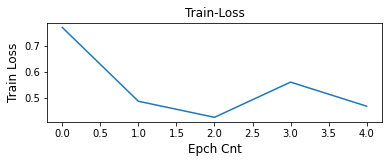

In [21]:
fig = plt.figure()
#Plot1
plot1 = fig.add_subplot(211)
plt.title("Train-Loss")
plt.xlabel('Epch Cnt', fontsize=12)
plt.ylabel('Train Loss', fontsize=12)
plot1.plot(train_loss, label='Train Loss')
